# 🏛️ **Veritas: The Adversarial AI Newsroom**
### *A Multi-Agent System for Combatting Misinformation*

## 🚀 Project Overview
In the age of viral rumors and AI hallucinations, trusting a single AI response is risky. Models often "hallucinate" to please the user or fail to critically analyze their own outputs.

**Veritas** is an agentic workflow that simulates a human newsroom. Instead of one AI answering a question, three distinct AI agents work together—and against each other—to find the truth.

## 🎯 The Problem
Standard LLMs suffer from:
1.  **Confirmation Bias:** They tend to agree with the user's prompt.
2.  **Hallucination:** They invent facts when they lack data.
3.  **Lack of Critical Thinking:** They rarely challenge the premise of a question.

## 💡 The Solution: Adversarial Architecture
Veritas solves this by using a **Sequential Multi-Agent Architecture** with distinct personas:

1.  **🕵️ Agent 1: The Researcher**
    *   **Role:** Gathers facts.
    *   **Tools:** Google Search Grounding.
    *   **Goal:** Find evidence *supporting* the claim.
    
2.  **🛡️ Agent 2: The Skeptic (Adversarial)**
    *   **Role:** The "Devil's Advocate."
    *   **Tools:** Logical Analysis.
    *   **Goal:** Attack the Researcher's findings. It looks for logical fallacies, bias, and missing context.
    
3.  **📰 Agent 3: The Editor-in-Chief**
    *   **Role:** The Judge.
    *   **Goal:** Synthesize the "Pro" and "Con" arguments into a final, unbiased verdict.

## 🛠️ Tech Stack
*   **Model:** Gemini 1.5 Flash (via Google GenAI API)
*   **Orchestration:** Python (Custom Sequential Logic)
*   **Tools:** Google Search Grounding (built-in Gemini Tool)
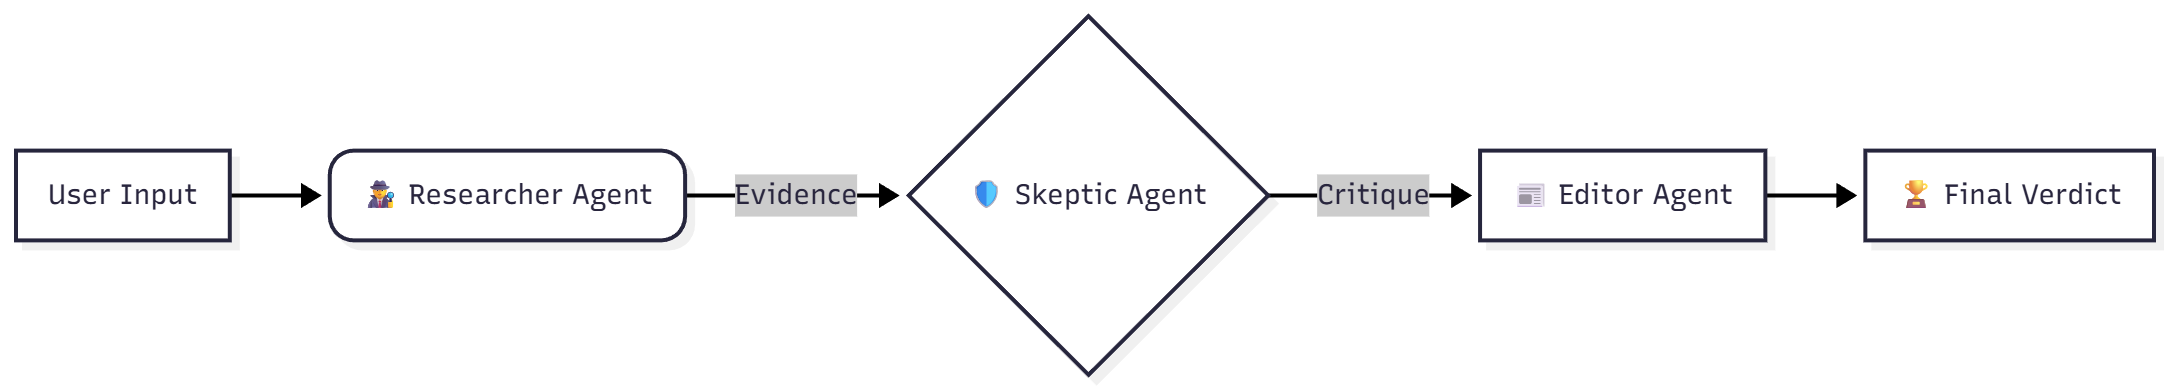


# 🎥 [Click Here to Watch the Project Demo (2 Mins)](https://www.loom.com/share/17dafb7d9a04446b9b1f4a4225361186)


---
*Scroll down to see the Agents in action!*

# Installation & Imports

In [1]:
!pip install -q markdown

import requests
import json
import time
import os
import markdown
from IPython.display import display, HTML
from typing import Tuple, List, Dict, Any
from kaggle_secrets import UserSecretsClient

# Configuration & Setup

In [2]:
try:
    user_secrets = UserSecretsClient()
    # "GOOGLE_API_KEY" matches the Label you gave in the Add-ons menu
    API_KEY = user_secrets.get_secret("GOOGLE_API_KEY") 
    MODEL_NAME = "gemini-2.5-flash-preview-09-2025"
    BASE_URL = f"https://generativelanguage.googleapis.com/v1beta/models/{MODEL_NAME}:generateContent"
    print("✅ API Key successfully retrieved from Kaggle Secrets.")
except Exception as e:
    print("❌ Error: Could not find 'GOOGLE_API_KEY' in Kaggle Secrets.")
    print("Step 1: Go to Add-ons -> Secrets")
    print("Step 2: Add a new secret with Label: GOOGLE_API_KEY")
    API_KEY = None

✅ API Key successfully retrieved from Kaggle Secrets.


# Core API Call Function

In [3]:
def call_gemini_api(system_prompt: str, user_query: str, use_search: bool = False, max_retries: int = 5) -> Tuple[str, List[Dict[str, Any]]]:
    """
    Core function to interact with Gemini API via raw HTTP requests.
    
    Design Choice:
    We use raw 'requests' instead of an SDK to have granular control over 
    the 'google_search' tool payload and error handling logic (exponential backoff).
    
    Args:
        system_prompt: The 'Persona' instructions (Researcher/Skeptic/Editor).
        user_query: The specific claim or text to process.
        use_search: If True, enables Google Search Grounding to minimize hallucinations.
    """

    if not API_KEY:
        return "Error: GEMINI_API_KEY is not set. Please set the API key.", []

    payload = {
        "contents": [{"parts": [{"text": user_query}]}],
        "systemInstruction": {"parts": [{"text": system_prompt}]},
    }

    if use_search:
        payload["tools"] = [{"google_search": {}}]

    headers = {'Content-Type': 'application/json'}

    for attempt in range(max_retries):
        try:
            response = requests.post(
                f"{BASE_URL}?key={API_KEY}",
                headers=headers,
                data=json.dumps(payload),
                timeout=45
            )
            response.raise_for_status()
            result = response.json()

            candidate = result.get('candidates', [{}])[0]
            text = candidate.get('content', {}).get('parts', [{}])[0].get('text', 'No response.')

            sources = []
            grounding = candidate.get('groundingMetadata')
            if grounding and grounding.get('groundingAttributions'):
                sources = grounding['groundingAttributions']

            return text, sources

        except requests.exceptions.RequestException:
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
            else:
                return "Error: API request failed after retries.", []

        except json.JSONDecodeError:
            return "Error: JSON decode failed.", []

    return "Unknown error.", []


# THE VERITAS DASHBOARD

In [4]:
def run_veritas_dashboard(claim):
    """
    Orchestrates the Multi-Agent workflow and renders the HTML Dashboard.
    Architecture: Sequential Chain (Researcher -> Skeptic -> Editor).
    """
    print(f"⏳ VERITAS IS INVESTIGATING: '{claim}'...")

    # =========================================================================
    # 🤖 AGENT WORKFLOW (Adversarial Design)
    # =========================================================================
    
    # 1. RESEARCHER AGENT (The Gatherer)
    # Behavior: Uses Google Search Tool to ground the response in external facts.
    # Design Goal: Minimize hallucination by forcing data retrieval first.
    researcher_prompt = "You are a Researcher. Search for facts. Use **bold** for key data. Keep it concise."
    evidence, sources = call_gemini_api(researcher_prompt, f"Find evidence for: {claim}", use_search=True)

    # 2. SKEPTIC AGENT (The Critic)
    # Behavior: Acts as a 'Devil's Advocate' to attack the Researcher's findings.
    # Design Goal: Identify logical fallacies, missing context, or bias that the Researcher missed.
    skeptic_prompt = "You are a Skeptic. Find flaws/missing context. Use **bold** for emphasis. Keep it concise."
    skeptic_input = f"Claim: {claim}\nEvidence: {evidence}"
    critique, _ = call_gemini_api(skeptic_prompt, skeptic_input, use_search=False)

    # 3. EDITOR AGENT (The Judge)
    # Behavior: Synthesizes the conflict between Evidence and Critique.
    # Design Goal: Produce a neutral, nuanced verdict (True/False/Misleading/Unsupported).
    editor_prompt = "You are an Editor. Provide a final verdict. Use **bold** for the decision."
    editor_input = f"Claim: {claim}\nEvidence: {evidence}\nCritique: {critique}"
    verdict, _ = call_gemini_api(editor_prompt, editor_input, use_search=False)

    # =========================================================================
    # 🎨 DASHBOARD RENDERING (UI Implementation)
    # =========================================================================
    
    # 1. Formatting: Convert Markdown (bold/lists) to HTML for clean display
    evidence_html = markdown.markdown(evidence)
    critique_html = markdown.markdown(critique)
    verdict_html = markdown.markdown(verdict)

    # 2. Styling: Force High-Contrast Colors (White text on dark backgrounds)
    # This ensures readability regardless of the user's browser theme (Dark/Light mode).
    dashboard_html = f"""
    <style>
        /* Force Text Colors to be readable */
        .researcher-box p, .researcher-box li {{ color: #333333 !important; line-height: 1.6; }}
        .skeptic-box p, .skeptic-box li {{ color: #333333 !important; line-height: 1.6; }}
        
        /* Force Verdict Text to be PURE WHITE */
        .verdict-box p, .verdict-box li, .verdict-box h1, .verdict-box h2, .verdict-box h3 {{ 
            color: #ffffff !important; 
            line-height: 1.6;
        }}
        /* Make links light blue in the dark box so they are visible */
        .verdict-box a {{ color: #4dabf7 !important; }}
    </style>

    <div style="font-family: Arial, sans-serif; border: 2px solid #2c3e50; border-radius: 10px; padding: 20px; background-color: #f8f9fa;">

        <h1 style="color: #2c3e50; border-bottom: 2px solid #2c3e50; padding-bottom: 10px; margin-top: 0;">
            🏛️ Veritas Newsroom Report
        </h1>

        <div style="background-color: #e8f6f3; padding: 15px; border-radius: 5px; margin-bottom: 20px; border: 1px solid #16a085;">
            <h3 style="margin-top: 0; color: #16a085;">🔍 The Claim</h3>
            <p style="font-size: 1.1em; font-weight: bold; color: #2c3e50; margin: 0;">"{claim}"</p>
        </div>

        <div style="display: flex; gap: 20px; flex-wrap: wrap;">

            <!-- LEFT COLUMN: The Debate -->
            <div style="flex: 2; min-width: 300px; display: flex; flex-direction: column; gap: 20px;">
                
                <!-- Researcher Output -->
                <div class="researcher-box" style="background-color: #ffffff; padding: 15px; border: 1px solid #bdc3c7; border-radius: 5px;">
                    <h4 style="color: #2980b9; margin-top: 0; border-bottom: 1px solid #eee; padding-bottom: 5px;">🕵️ Researcher's Evidence</h4>
                    {evidence_html}
                </div>

                <!-- Skeptic Output -->
                <div class="skeptic-box" style="background-color: #fff0f0; padding: 15px; border: 1px solid #e74c3c; border-radius: 5px;">
                    <h4 style="color: #c0392b; margin-top: 0; border-bottom: 1px solid #ffcccc; padding-bottom: 5px;">🛡️ Skeptic's Analysis</h4>
                    {critique_html}
                </div>
            </div>

            <!-- RIGHT COLUMN: The Verdict -->
            <div class="verdict-box" style="flex: 1; min-width: 250px; background-color: #2c3e50; padding: 20px; border-radius: 5px;">
                <h2 style="margin-top: 0; border-bottom: 1px solid #ecf0f1; padding-bottom: 10px; text-align:center; color: white !important;">
                    🏆 FINAL VERDICT
                </h2>
                {verdict_html}
            </div>

        </div>
    </div>
    """
    
    display(HTML(dashboard_html))

## 🤖 Test Case 1: The "Speculation" Test
**Claim:** "AI Agents will replace 80% of junior software developers by the end of 2026."

*   **Why we tested this:** This is a complex future prediction involving "AI Hype." It forces the agents to distinguish between **viral opinion articles** (which predict doom) and **authoritative economic data** (which predicts role transformation).
*   **Expected Behavior:** The **Skeptic** should catch that the "80%" figure lacks support from major research firms (like Gartner or Forrester) and is likely an exaggeration, leading to an "Unsupported" verdict.

In [5]:
run_veritas_dashboard("AI Agents will replace 80% of junior software developers by the end of 2026.")

⏳ VERITAS IS INVESTIGATING: 'AI Agents will replace 80% of junior software developers by the end of 2026.'...


## 📱 Test Case 2: The "Nuance" Test
**Claim:** "Leaving your smartphone plugged in overnight destroys the battery lifespan."

*   **Why we tested this:** This is a common concern where physics (heat is bad) conflicts with engineering (modern chips prevent overcharging).
*   **Expected Behavior:** The **Skeptic** should identify that modern Battery Management Systems (BMS) mitigate the theoretical damage found by the **Researcher**.

In [6]:
run_veritas_dashboard("Leaving your smartphone plugged in overnight destroys the battery lifespan.")

⏳ VERITAS IS INVESTIGATING: 'Leaving your smartphone plugged in overnight destroys the battery lifespan.'...


## 🧱 Test Case 3: The "Myth" Test
**Claim:** "The Great Wall of China is the only man-made object visible from space with the naked eye."

*   **Why we tested this:** A popular factoid that is actually false.
*   **Expected Behavior:** The **Researcher** might find sources repeating the myth, but the **Skeptic** should find NASA/Astronaut sources debunking it (it's too narrow to see).

In [7]:
run_veritas_dashboard("The Great Wall of China is the only man-made object visible from space with the naked eye.")

⏳ VERITAS IS INVESTIGATING: 'The Great Wall of China is the only man-made object visible from space with the naked eye.'...
